# Findings 5
Dated: 30.06.2025

# imports

In [1]:
import sys
import os
import numpy as np
import pandas as pd
from itertools import product
from IPython.display import clear_output

# Get the notebook's current directory
notebook_dir = os.getcwd()

# Move one level up to get the parent directory
parent_dir = os.path.dirname(notebook_dir)

# Add the parent directory to sys.path
sys.path.append(parent_dir)

from module import *

/opt/anaconda3/envs/cqr/lib/python3.11/site-packages/do_mpc/sysid/__init__.py:15: UserWarning: The ONNX feature is not available. Please install the full version of do-mpc to access this feature.
  warnings.warn('The ONNX feature is not available. Please install the full version of do-mpc to access this feature.')
/opt/anaconda3/envs/cqr/lib/python3.11/site-packages/do_mpc/opcua/__init__.py:14: UserWarning: The opcua feature is not available. Please install the full version of do-mpc to access this feature.
  warnings.warn('The opcua feature is not available. Please install the full version of do-mpc to access this feature.')


# computation device
This variable sets the device to be used for the Neural Network trainings:

In [2]:
computation_device = 'auto'

In [3]:
def _save_results(results_dicts):
    filename = 'results_no_plot.csv'

    try:
        df = pd.read_csv(filename)
    except FileNotFoundError:
        df = pd.DataFrame()

    # check if df is empty, assign a new column name 'Serial No.' and add it to all dicts
    if df.empty:
        for i, result_dict in enumerate(results_dicts, start=1):
            result_dict['Serial No.'] = i

    # df is not empty, assign the next serial number
    else:
        last_serial_no = df['Serial No.'].max()
        for result_dict in results_dicts:
            last_serial_no += 1
            result_dict['Serial No.'] = last_serial_no

    # Convert the list of dictionaries to a DataFrame
    new_df = pd.DataFrame(results_dicts)

    # put the 'Serial No.' as the first column
    new_df = new_df[['Serial No.'] + [col for col in new_df.columns if col != 'Serial No.']]

    # Append the new DataFrame to the existing one
    df = pd.concat([df, new_df], ignore_index=True)

    # Save the updated DataFrame to the CSV file
    df.to_csv(filename, index=False)

# system init
This is a generic spring damper setup. Very simple and linear, with two states and one input. The state euation is the force balance of a spring damper.

In [4]:
cstr_system = CSTR_dompc()

Modifying constraints

In [5]:
#spring_system.lbu = np.array([-10])       # [lower_bound_f_ext]
#spring_system.ubu = np.array([10])        # [upper_bound_f_ext]

# surrogate generator init
This class is designed to be totally generic, i.e., it can take any do-mpc model, or at least that is the idea.

In [6]:
dm = DataManager(set_seed=0)

# random data

Here we generate sampled with one random initial point and random inputs. Then the data and the data is split randomly to feed different parts of the algorithm.
There is another alternate algorithm which generates data by chasing random setpoints with the help of an MPC controller.

In [7]:
dm.random_input_sampler(system = cstr_system, n_samples=1000)
dm.data_splitter(order=1, narx_train= 0.3, cqr_train= 0.3, cqr_calibration= 0.3, test = 0.1)
#dm.data_splitter(order=2)

Generating data: 100%|██████████| 1000/1000 [00:00<00:00, 3469.71it/s]


## data visualisation

/Users/sourjyanaskar/Library/CloudStorage/OneDrive-Personal/tu_d/Thesis/icb_mpc/module/_graphics.py:124: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.legend()


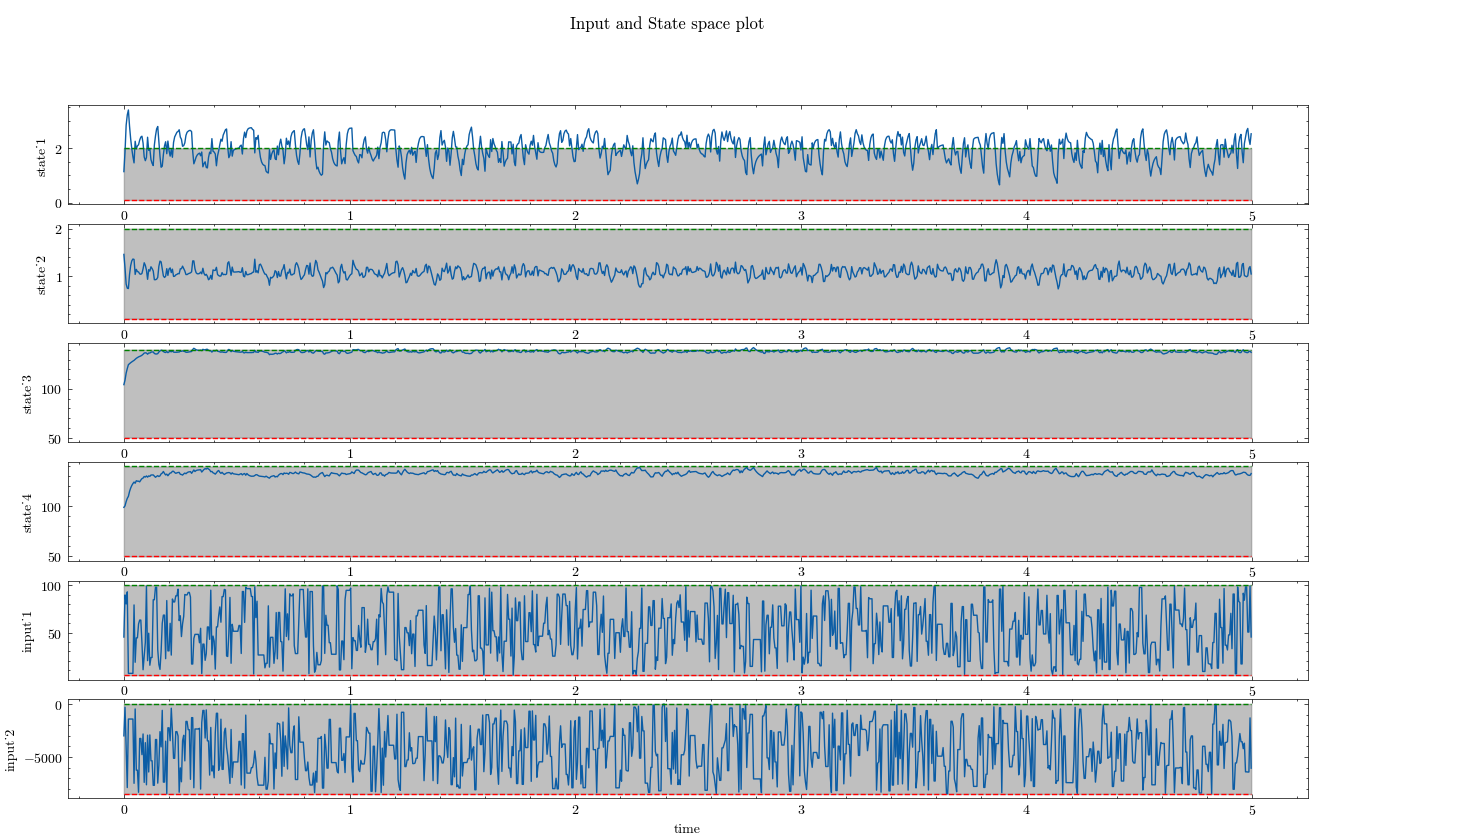

In [8]:
dm.visualize_data()

# NARX model

Training NARX:   5%|▌         | 51/1000 [00:00<00:01, 770.38it/s]


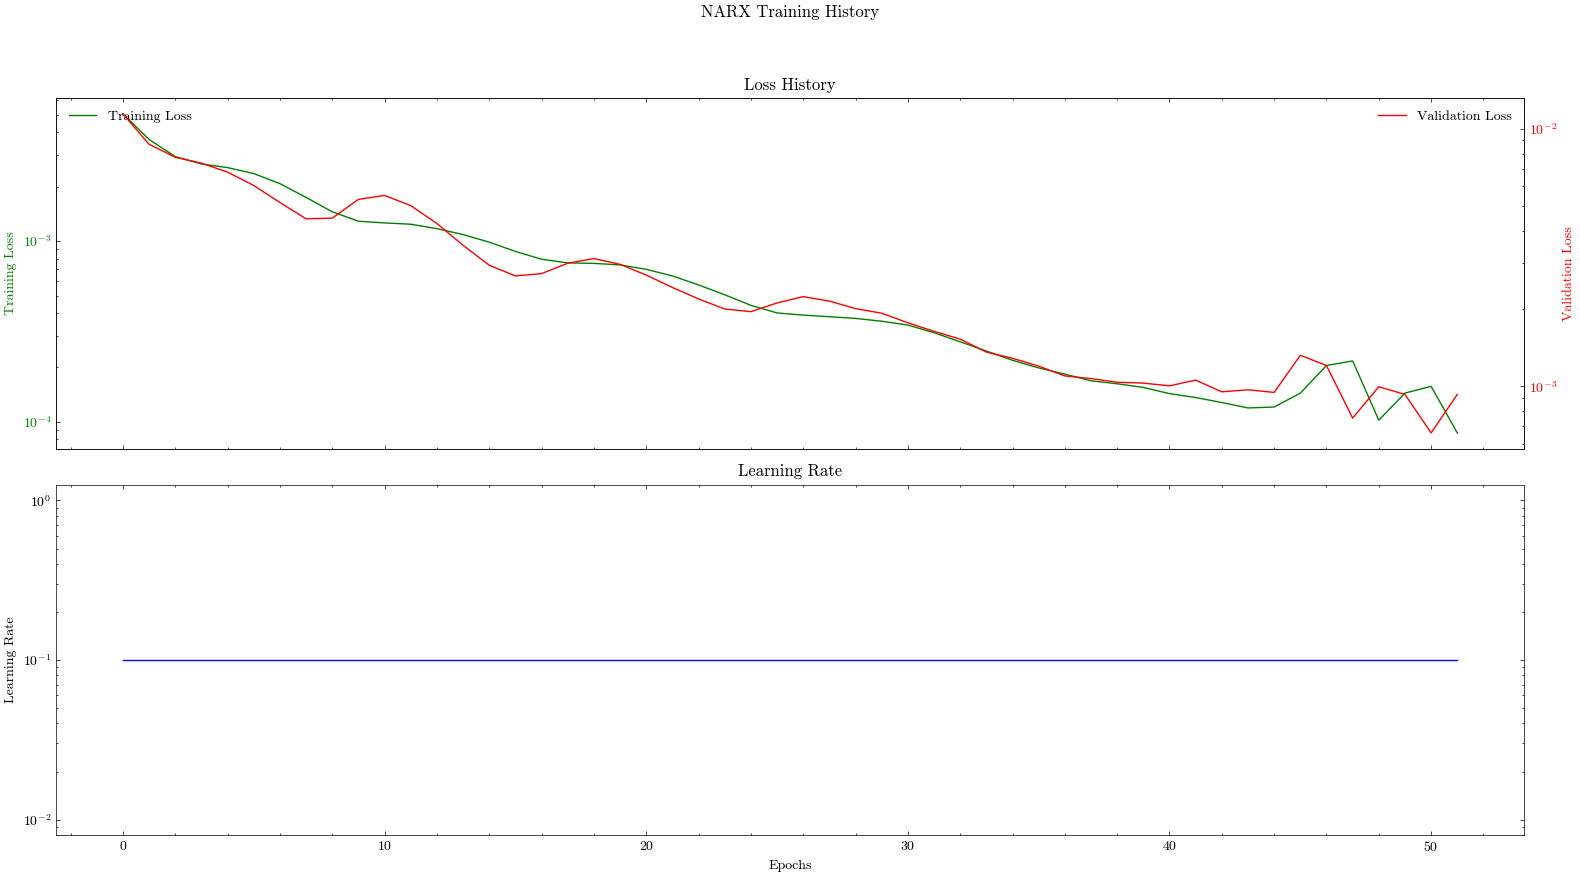

In [9]:
dm.train_narx(hidden_layers=[5], batch_size=1000,
          learning_rate=0.1, epochs= 1000, scheduler_flag=True, device=computation_device, train_threshold=1e-4)
dm.narx.plot_narx_training_history()

# conformal quantile regression
Here qunatile regression is done to bound the errors with confidence values

Training Cqr q= 0.025: 100%|██████████| 1000/1000 [00:01<00:00, 823.45it/s]


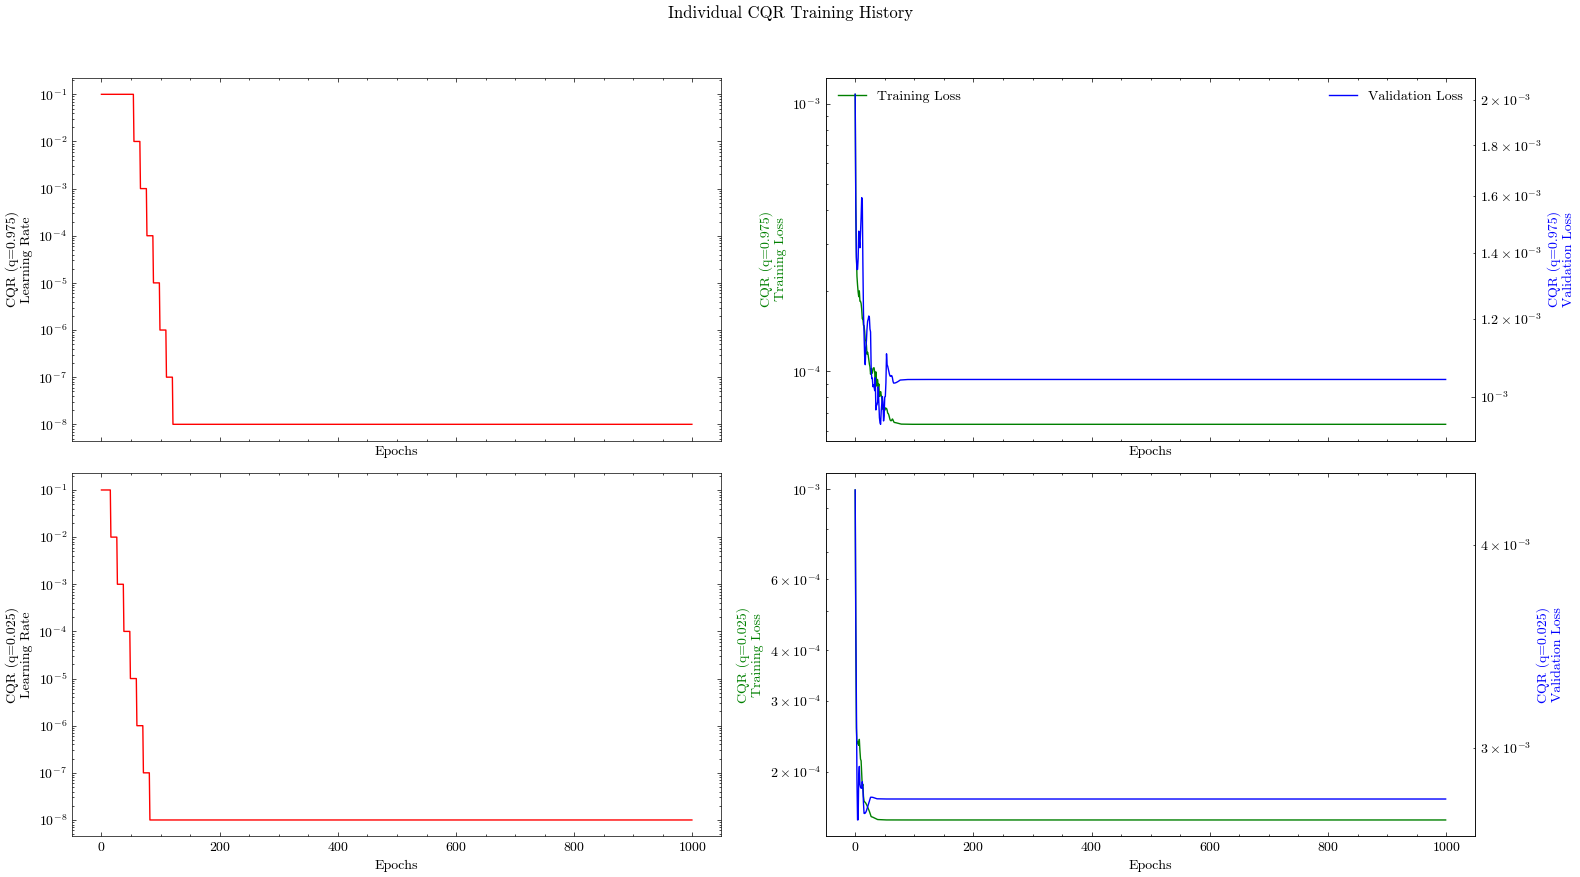

In [10]:
dm.train_cqr(alpha=0.05, hidden_layers=[10, 10],  epochs= 1000, batch_size=1000, 
             device=computation_device, train_threshold=1e-20)
dm.cqr.plot_qr_training_history()

This section visualises the quantile regression on the calibration data which the regressors has yet not seen.

In [11]:
dm.cqr_plot_qr_error()

This plot is made against test data which till now is untouched.

In [12]:
dm.plot_cqr_error_plotly()

# verifying simulator performance

In [13]:
# checking simulator performance
C_a0 = 0.8 # This is the initial concentration inside the tank [mol/l]
C_b0 = 0.5 # This is the controlled variable [mol/l]
T_R0 = 134.14 #[C]
T_K0 = 130.0 #[C]

#C_a0 = 0
#C_b0 = 0
#T_R0 = 387.05
#T_J0 = 387.05

x_init = np.random.uniform(cstr_system.lbx, cstr_system.ubx).reshape((1, -1))
dm.check_simulator(system=cstr_system, iter= 50, x_init=x_init)



-------- Pytorch NARX Model -> do-mpc model --------

state_1_lag_0 <<--- @1=((state_1_lag_0-1.99805)/0.445503), @2=((state_2_lag_0-1.085)/0.102507), @3=((state_3_lag_0-138.031)/2.66284), @4=((state_4_lag_0-132.837)/3.44518), @5=((input_1_lag_0-52.7393)/27.14), @6=((input_2_lag_0--4538.43)/2310.09), @7=(((((((-0.0145895*@1)+(0.070241*@2))+(0.222193*@3))+(-0.15986*@4))+(-0.378614*@5))+(-0.108998*@6))+-0.261382), @8=(((((((-0.289861*@1)+(-0.16935*@2))+(-0.0667717*@3))+(0.233997*@4))+(0.0830855*@5))+(0.0970217*@6))+-0.400167), @9=(((((((0.358724*@1)+(-0.05347*@2))+(0.279217*@3))+(0.0532562*@4))+(0.457137*@5))+(-0.0101205*@6))+0.0843768), @10=(((((((-0.17901*@1)+(-0.158372*@2))+(0.254712*@3))+(0.0417154*@4))+(0.140031*@5))+(0.0934417*@6))+0.997132), @11=(((((((-0.411683*@1)+(-0.24614*@2))+(-0.0365185*@3))+(-0.084943*@4))+(0.296823*@5))+(-0.119418*@6))+0.0767508), ((0.434075*((((((-1.51094*((exp(@7)-exp((-@7)))/(exp(@7)+exp((-@7)))))+(-1.09337*((exp(@8)-exp((-@8)))/(exp(@8)+exp((-@8))))))

# iterative case study report

In [14]:
iter = 50
setpoint = None
counter = 1

In [15]:
lqr_r_list = [10, 50, 100]
lqr_q_list = [1]
tightner_list = [0.8, 1, 1.2]
confidence_cutoff_list = [0.8, 0.85, 0.9]
rnd_samples_list = [1, 3, 7]
max_search_list = [3, 5, 10]
r_horizon_list = [3, 5, 7]
n_horizon_list = [10, 15, 20]
r_list = [0.01, 0.05, 0.1]

permutations = product(lqr_r_list, lqr_q_list, tightner_list, 
                       confidence_cutoff_list, rnd_samples_list, max_search_list, 
                       r_horizon_list, n_horizon_list, r_list)

n_possible_cases = len(lqr_r_list) * len(lqr_q_list) * len(tightner_list) * \
                    len(confidence_cutoff_list) * len(rnd_samples_list) * \
                    len(max_search_list) * len(r_horizon_list) * \
                    len(n_horizon_list) * len(r_list)

In [ ]:
for lqr_r, lqr_q, tightner, confidence_cutoff, rnd_samples, max_search, r_horizon, n_horizon, r in permutations:

    # init
    results_dicts = []
    R = lqr_r * np.array([[1 / (95 * 95), 0],
                          [0, 1 / (8500 * 8500)]])
    Q = lqr_q * np.array([[1 / (1.9 * 1.9), 0, 0, 0],
                          [0, 1 / (1.9 * 1.9), 0, 0],
                          [0, 0, 1 / (90 * 90), 0],
                          [0, 0, 0, 1 / (90 * 90)]])
    x_init = np.random.uniform(cstr_system.lbx, cstr_system.ubx).reshape((-1, 1))

    # case study 1
    print(f"Running case study 1 : {counter}/{n_possible_cases} ---->>>")
    cs1 = dm.case_study_1(system=cstr_system, iter=iter, setpoint=setpoint,
                          n_horizon=n_horizon, r=r,
                          tightner=tightner, confidence_cutoff=confidence_cutoff,
                          rnd_samples=rnd_samples, max_search=max_search, R=R, Q=Q,
                          x_init=x_init, store_gif=False)
    cs1['LQR r'] = lqr_r
    cs1['LQR q'] = lqr_q
    results_dicts.append(cs1)

    # clear output
    clear_output(wait=True)

    # case study 2
    print(f"Running case study 2 : {counter}/{n_possible_cases} ---->>>")
    dm.setup_case_study_2(hidden_layers=[10, 10], system=cstr_system, setpoint=setpoint,
                          n_horizon=n_horizon, r=r, epochs=1000, batch_size=1000)
    cs2 = dm.case_study_2(system=cstr_system, iter=iter, x_init=x_init)
    results_dicts.append(cs2)

    # clear output
    clear_output(wait=True)

    # case study 3
    print(f"Running case study 3 : {counter}/{n_possible_cases} ---->>>")
    dm.setup_case_study_3(system=cstr_system, n_horizon=n_horizon, r_horizon=r_horizon, r=r, setpoint=setpoint)
    cs3 = dm.case_study_3(system=cstr_system, iter=iter, x_init=x_init)
    cs3['MPC Robust Horizon'] = r_horizon
    results_dicts.append(cs3)

    # clear output
    clear_output(wait=True)

    # case study 4
    print(f"Running case study 4 : {counter}/{n_possible_cases} ---->>>")
    dm.setup_case_study_4(system=cstr_system, n_horizon=n_horizon, r=r, setpoint=setpoint)
    cs4 = dm.case_study_4(system=cstr_system, iter=iter, x_init=x_init)
    results_dicts.append(cs4)

    # clear output
    clear_output(wait=True)

    # case study 5
    print(f"Running case study 5 : {counter}/{n_possible_cases} ---->>>")
    cs5 = dm.case_study_5(system=cstr_system, iter=iter, setpoint=setpoint,
                          n_horizon=n_horizon, r=r,
                          tightner=tightner, confidence_cutoff=confidence_cutoff, rnd_samples=rnd_samples,
                          max_search=max_search,
                          x_init=x_init, store_gif=False)
    results_dicts.append(cs5)

    # clear output
    clear_output(wait=True)

    # result storage
    _save_results(results_dicts)

    # counter update
    counter += 1